In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from scipy.ndimage import gaussian_filter1d

# 1. 데이터 로드
file_path = '/Users/a0000/Desktop/cafe 1 data.csv'
df = pd.read_csv(file_path, encoding='utf-8-sig')
df.columns = ['date', 'time', 'detected_people']  # 컬럼명 지정

# 2. 시간 변환
df['date'] = pd.to_datetime(df['date'])  # 날짜를 datetime 형식으로 변환
df['time'] = pd.to_timedelta(df['time']).dt.total_seconds().astype(int)  # 시간 컬럼을 초 단위로 변환

# 3. Gaussian 스무딩
sigma = 10  # 스무딩 강도
df['detected_people_smoothed'] = gaussian_filter1d(df['detected_people'], sigma)

# 4. Min-Max 스케일링
scaler = MinMaxScaler()  # 스케일러 생성
df['scaled_detected_people'] = scaler.fit_transform(df[['detected_people_smoothed']])  # 스무딩된 값을 스케일링


In [2]:
# 학습 데이터 생성
time_window = 6  # 입력 시퀀스 길이
prediction_time = 6  # 예측할 시간 이후의 데이터

x_train, y_train = [], []
for i in range(len(df) - time_window - prediction_time):
    x_train.append(df['scaled_detected_people'].iloc[i:i + time_window].values)
    y_train.append(df['scaled_detected_people'].iloc[i + time_window + prediction_time])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))  # (samples, time_steps, features)


In [3]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.losses import MeanSquaredLogarithmicError
from tensorflow.keras.optimizers import Adam

# Seq2Seq 모델 정의
class Seq2SeqModel(Model):
    def __init__(self, units, time_window, **kwargs):
        super(Seq2SeqModel, self).__init__(**kwargs)
        self.units = units
        self.time_window = time_window
        self.encoder = layers.LSTM(units=self.units, return_sequences=True)
        self.decoder = layers.LSTM(units=self.units, return_sequences=False)
        self.output_layer = layers.Dense(1)

    def call(self, inputs):
        encoder_outputs = self.encoder(inputs)
        decoder_outputs = self.decoder(encoder_outputs[:, -self.time_window:, :])
        output = self.output_layer(decoder_outputs)
        return output

# 모델 생성
seq2seq_model = Seq2SeqModel(units=100, time_window=time_window)
seq2seq_model.compile(optimizer=Adam(), loss=MeanSquaredLogarithmicError())
seq2seq_model.fit(x_train, y_train, epochs=3, batch_size=10, verbose=1)


Epoch 1/3
296/296 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0115
Epoch 2/3
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0020
Epoch 3/3
296/296 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0019


93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


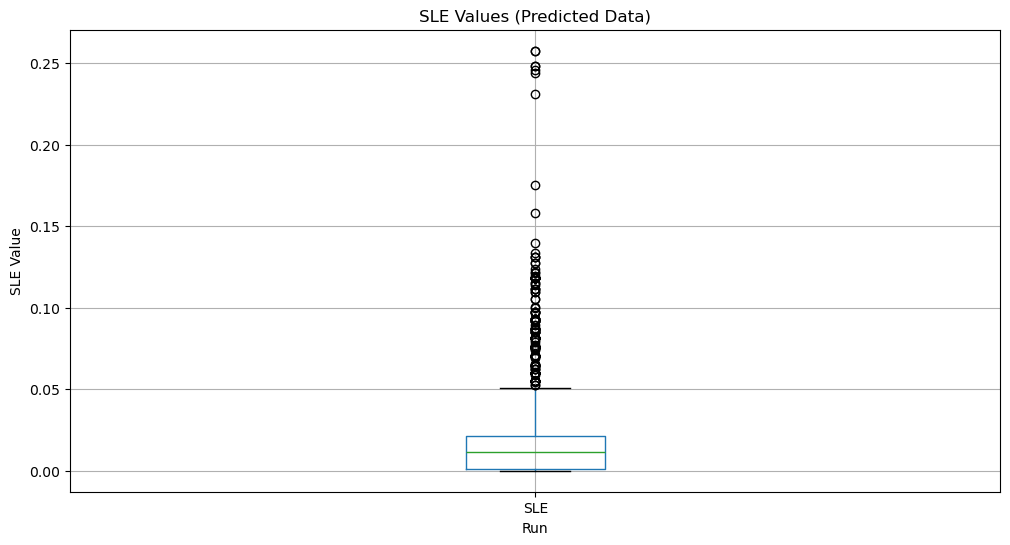

In [4]:
# 예측 생성
predicted_values = seq2seq_model.predict(x_train)
predicted_values = scaler.inverse_transform(predicted_values)

# 실제 값과 예측값의 SLE(Squared Logarithmic Error) 계산
SLE = np.square(np.log1p(df['detected_people'][-len(predicted_values):].values) - np.log1p(predicted_values.flatten()))

# SLE를 DataFrame으로 변환하고 CSV 파일로 저장
SLE_df = pd.DataFrame({'SLE': SLE})
SLE_df.to_csv('/Users/a0000/Desktop/SLE_values.csv', index=False)

# SLE 시각화
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
SLE_df.boxplot()
plt.title("SLE Values (Predicted Data)")
plt.xlabel("Run")
plt.ylabel("SLE Value")
plt.show()


MovieWriter imagemagick unavailable; using Pillow instead.


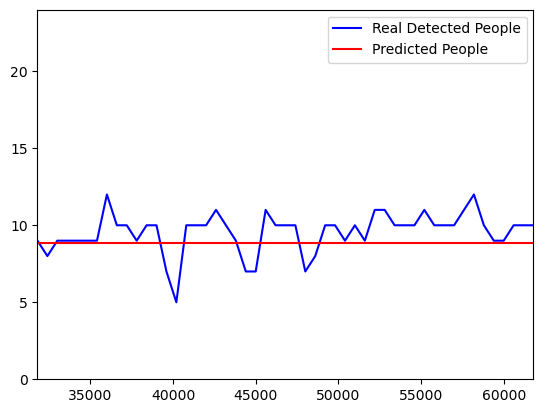

In [6]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# 실시간 시각화용 데이터 초기화
real_data = pd.DataFrame({'time': df['time'][:len(predicted_values)], 'detected_people': df['detected_people'][:len(predicted_values)]})
predicted_data = pd.DataFrame({'time': df['time'][:len(predicted_values)], 'predicted_people': predicted_values.flatten()})

# 그래프 초기화
fig, ax = plt.subplots()
real_line, = ax.plot([], [], label='Real Detected People', color='blue')
predicted_line, = ax.plot([], [], label='Predicted People', color='red')
plt.legend()

# 업데이트 함수 정의
def update(frame):
    start_idx = max(0, frame - 50)
    end_idx = frame + 1
    
    # x축 범위 확인 및 설정
    if real_data['time'].iloc[start_idx] == real_data['time'].iloc[end_idx - 1]:
        ax.set_xlim(real_data['time'].iloc[start_idx] - 10, real_data['time'].iloc[end_idx - 1] + 10)
    else:
        ax.set_xlim(real_data['time'].iloc[start_idx], real_data['time'].iloc[end_idx - 1])
    
    # y축 범위 설정
    ax.set_ylim(0, max(real_data['detected_people'].max(), predicted_data['predicted_people'].max()) + 5)
    
    # 데이터 업데이트
    real_line.set_data(real_data['time'].iloc[start_idx:end_idx], real_data['detected_people'].iloc[start_idx:end_idx])
    predicted_line.set_data(predicted_data['time'].iloc[start_idx:end_idx], predicted_data['predicted_people'].iloc[start_idx:end_idx])
    
    return real_line, predicted_line

# 애니메이션 생성
ani = FuncAnimation(fig, update, frames=len(predicted_values), interval=100, blit=False)

# 애니메이션 저장
ani.save('/Users/a0000/Desktop/real_time_prediction.gif', writer='imagemagick', fps=10)
plt.show()
